# Project code

gg

In [95]:
import os
from pathlib import Path
import time

import cv2
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, UnidentifiedImageError
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.random_projection import GaussianRandomProjection
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import tensorly as tl
import torch
from torchvision.datasets import MNIST, EMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, random_split
from torchvision import datasets
from torchvision.transforms import v2

def tic():
    return time.time()
def toc(tstart, name="Operation", printtime=True):
    dt = time.time() - tstart
    if printtime:
        print("%s took: %s sec.\n" % (name, dt))
    return dt

## Data loading utilities

In [265]:
class CharDataset(Dataset):
    """
    General dataset for single character data loading.

    Assumes that in the directory given, the subdirectories are the classes.
    These directory names should be the single character class.
    """
    def __init__(self, img_dir, transform=None):
        self.img_dir = Path(img_dir)
        if not self.img_dir.exists():
            raise FileNotFoundError(f"{img_dir} does not exist")
        alldirs = [p for p in self.img_dir.glob("*") if p.is_dir()]
        self.imgpaths = []
        self.imglabels = []
        for d in alldirs:
            chclass = d.stem.lower()
            imgpaths_dirty = list(d.glob("*.jpg")) + list(d.glob("*.png"))
            imgpaths = []
            for i in range(len(imgpaths_dirty)):
                # cv2 imread is ~3x faster than Image.open
                cv2opened = cv2.imread(str(imgpaths_dirty[i]))
                if cv2opened is None:
                    print(f"Image {imgpaths_dirty[i]} is not a valid image, skipping")
                    continue
                imgpaths.append(imgpaths_dirty[i])
            self.imgpaths.extend(imgpaths)
            self.imglabels.extend([chclass] * len(imgpaths))
        self.transform = transform

    def __len__(self):
        return len(self.imglabels)

    def __getitem__(self, idx):
        imgpath = self.imgpaths[idx]
        img = Image.open(imgpath).convert("L")
        label = self.imglabels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label
    
def ds_to_vectors(ds, size=28):
    imgs = np.array([np.array(x[0].resize((28, 28))).reshape(-1) for x in ds])
    labs = np.array([x[1] for x in ds])
    return imgs, labs

In [266]:
randomrot_T = v2.Compose([
    v2.PILToTensor(),
    v2.RandomRotation(45),
    v2.ToPILImage()
])

In [267]:
# this dataset is already random rotated
handiso_ds_train = CharDataset("data/handwritten-isolated-english/train")
handiso_ds_test = CharDataset("data/handwritten-isolated-english/test")
handiso_test_data, handiso_test_labels = ds_to_vectors(handiso_ds_test)

notmnist_ds = CharDataset("data/notMNIST_small", transform=randomrot_T)
notmnist_ds_train, notmnist_ds_test = random_split(notmnist_ds, [0.8, 0.2])
notmnist_test_data, notmnist_test_labels = ds_to_vectors(notmnist_ds_test)

stdocr_ds_train_orig = CharDataset("data/standard_ocr_dataset/data/training_data", transform=randomrot_T) + CharDataset("data/standard_ocr_dataset/data2/training_data", transform=randomrot_T)
stdocr_ds_test = CharDataset("data/standard_ocr_dataset/data/testing_data", transform=randomrot_T) + CharDataset("data/standard_ocr_dataset/data2/testing_data", transform=randomrot_T)
stdocr_test_data, stdocr_test_labels = ds_to_vectors(stdocr_ds_test)

mnist_ds_train_orig = EMNIST(Path(os.getcwd(), "data"), "byclass", download=True, train=True, transform=randomrot_T, target_transform=str)
mnist_ds_test_orig = EMNIST(Path(os.getcwd(), "data"), "byclass", download=True, train=False, transform=randomrot_T, target_transform=str)

Image data/notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png is not a valid image, skipping
Image data/notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png is not a valid image, skipping
Image data/standard_ocr_dataset/data2/testing_data/G/44404.png is not a valid image, skipping


In [27]:
print(f"handwritten-isolated-english sizes: [train:{len(handiso_ds_train)}, test:{len(handiso_ds_test)}]")
print(f"not MNIST sizes: [train:{len(notmnist_ds_train)}, test:{len(notmnist_ds_test)}]")
print(f"standard OCR ds sizes: [train:{len(stdocr_ds_train_orig)}, test:{len(stdocr_ds_test)}]")
print(f"EMNIST sizes: [train:{len(mnist_ds_train_orig)}, test:{len(mnist_ds_test_orig)}]")

handwritten-isolated-english sizes: [train:13168, test:1792]
not MNIST sizes: [train:14980, test:3744]
standard OCR ds sizes: [train:41256, test:4249]
EMNIST sizes: [train:697932, test:116323]


In [28]:
# EMNIST dataset is way too large for our purposes, we only take a subset of it
stdocr_ds_train, _ = random_split(stdocr_ds_train_orig, [0.5, 0.5])
mnist_ds_train, _ = random_split(mnist_ds_train_orig, [0.03, 0.97])
mnist_ds_test, _ = random_split(mnist_ds_test_orig, [0.05, 0.95])
mnist_test_data, mnist_test_labels = ds_to_vectors(mnist_ds_test)

In [29]:
print(f"handwritten-isolated-english sizes: [train:{len(handiso_ds_train)}, test:{len(handiso_ds_test)}]")
print(f"not MNIST sizes: [train:{len(notmnist_ds_train)}, test:{len(notmnist_ds_test)}]")
print(f"standard OCR ds sizes: [train:{len(stdocr_ds_train)}, test:{len(stdocr_ds_test)}]")
print(f"EMNIST sizes: [train:{len(mnist_ds_train)}, test:{len(mnist_ds_test)}]")

handwritten-isolated-english sizes: [train:13168, test:1792]
not MNIST sizes: [train:14980, test:3744]
standard OCR ds sizes: [train:20628, test:4249]
EMNIST sizes: [train:20938, test:5817]


In [30]:
consolidated_ds_train = handiso_ds_train + notmnist_ds_train + stdocr_ds_train + mnist_ds_train
cons_train_data, cons_train_labels = ds_to_vectors(consolidated_ds_train)
consolidated_ds_test = handiso_ds_test + notmnist_ds_test + stdocr_ds_test + mnist_ds_test
cons_test_data, cons_test_labels = ds_to_vectors(consolidated_ds_test)

## Utility functions for model setup and testing

In [236]:
def run_all_tests_model(model, data_transform=None):
    if data_transform is None:
        data_transform = lambda x: x
    ts = tic()
    handwrscore = model.score(data_transform(handiso_test_data), handiso_test_labels)
    notmnistscore = model.score(data_transform(notmnist_test_data), notmnist_test_labels)
    stdocrscore = model.score(data_transform(stdocr_test_data), stdocr_test_labels)
    mnistscore = model.score(data_transform(mnist_test_data), mnist_test_labels)
    toc(ts, "Model testing")
    tot_test = len(handiso_test_labels) + len(notmnist_test_labels) + len(stdocr_test_labels) + len(mnist_test_labels)
    weighted_score = (handwrscore * len(handiso_test_labels) + notmnistscore * len(notmnist_test_labels) + stdocrscore * len(stdocr_test_labels) + mnistscore * len(mnist_test_labels)) / tot_test
    print(f"handwritten-isolated score: {handwrscore}\n"
          f"notMNIST score: {notmnistscore}\n"
          f"standard OCR score: {stdocrscore}\n"
          f"EMNIST score: {mnistscore}\n"
          f"Aggregate score: {weighted_score}")
    return handwrscore, notmnistscore, stdocrscore, mnistscore, weighted_score

def test_trf_models(create_model_func, trf_funcs, mincomps, maxcomps):
    """
    create_model_func: (X, y, data_transform=func) -> scipy classification model
    """
    assert len(trf_funcs) == (maxcomps + 1) - mincomps
    handwrscores, notmnistscores, stdocrscores, mnistscores, aggscores = [], [], [], [], []
    traintimes, predicttimes = [], []
    for ncomp in range(mincomps, maxcomps + 1):
        print(f"n_components: {ncomp}")
        trf = trf_funcs[ncomp - mincomps]
        ts = tic()
        consol_model = create_model_func(cons_train_data, cons_train_labels, data_transform=trf)
        traintimes.append(toc(ts, printtime=False))
        ts = tic()
        handwrscore, notmnistscore, stdocrscore, mnistscore, aggscore = run_all_tests_model(consol_model, data_transform=trf)
        predicttimes.append(toc(ts, printtime=False))
        handwrscores.append(handwrscore)
        notmnistscores.append(notmnistscore)
        stdocrscores.append(stdocrscore)
        mnistscores.append(mnistscore)
        aggscores.append(aggscore)
        print("------")
    return {
        "handwrscores": handwrscores,
        "notmnistscores": notmnistscores,
        "stdocrscores": stdocrscores,
        "mnistscores": mnistscores,
        "aggscores": aggscores,
        "traintimes": traintimes,
        "predicttimes": predicttimes
    }

def plot_scores(results, ncomplist, title="Classification results for dimensionality reduction"):
    fig, ax = plt.subplots()
    ax.plot(ncomplist, results["handwrscores"], "-", label="handwritten-isolated")
    ax.plot(ncomplist, results["notmnistscores"], "-", label="notMNIST")
    ax.plot(ncomplist, results["stdocrscores"], "-", label="standard OCR")
    ax.plot(ncomplist, results["mnistscores"], "-", label="EMNIST")
    ax.plot(ncomplist, results["aggscores"], "--", label="aggregated")
    ax.set_xlabel("number of components")
    ax.set_ylabel("test accuracy")
    ax.legend()
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

In [32]:
def create_logreg(X, y, data_transform=None):
    if data_transform is None:
        data_transform = lambda x: x
    ts = tic()
    logreg = LogisticRegression()
    logreg.fit(data_transform(X), y)
    toc(ts, "Logistic Regression training")
    return logreg

def create_knn(X, y, k=5, data_transform=None):
    if data_transform is None:
        data_transform = lambda x: x
    ts = tic()
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(data_transform(X), y)
    toc(ts, "KNN training")
    return knn

## Raw model tests

In [33]:
# logistic regression linear classifier
consol_logreg = create_logreg(cons_train_data, cons_train_labels)
run_all_tests_model(consol_logreg)

Logistic Regression training took: 48.82743978500366 sec.

Model testing took: 0.11310791969299316 sec.

handwritten-isolated score: 0.04575892857142857
notMNIST score: 0.594551282051282
standard OCR score: 0.4575194163332549
EMNIST score: 0.4156781846312532
Aggregate score: 0.4275092936802974


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.04575892857142857,
 0.594551282051282,
 0.4575194163332549,
 0.4156781846312532,
 0.4275092936802974)

In [34]:
# KNN classifier
consol_knn = create_knn(cons_train_data, cons_train_labels, k=5)
run_all_tests_model(consol_knn)

KNN training took: 0.012620210647583008 sec.



Model testing took: 20.23938822746277 sec.

handwritten-isolated score: 0.6037946428571429
notMNIST score: 0.7943376068376068
standard OCR score: 0.8945634266886326
EMNIST score: 0.6384734399174833
Aggregate score: 0.741635687732342


(0.6037946428571429,
 0.7943376068376068,
 0.8945634266886326,
 0.6384734399174833,
 0.741635687732342)

## Tests with PCA

In [35]:
def create_pca(X, n_components):
    ts = tic()
    pca = PCA(n_components=n_components)
    pca.fit(X)
    toc(ts, "Creating PCA components")
    return pca

# could probably just initialize PCA with max components first, then just subset the
# eigenvectors, but I'm too lazy to do that
allpcas = [create_pca(cons_train_data, i) for i in range(2, 60)]
pcatrf_funcs = [pca.transform for pca in allpcas]

Creating PCA components took: 1.2295076847076416 sec.

Creating PCA components took: 1.1204259395599365 sec.

Creating PCA components took: 1.2547318935394287 sec.

Creating PCA components took: 1.030271053314209 sec.

Creating PCA components took: 1.0659122467041016 sec.

Creating PCA components took: 1.4166457653045654 sec.

Creating PCA components took: 1.0996711254119873 sec.

Creating PCA components took: 1.261625051498413 sec.

Creating PCA components took: 1.8473091125488281 sec.

Creating PCA components took: 2.3437047004699707 sec.

Creating PCA components took: 2.319098949432373 sec.

Creating PCA components took: 2.361751079559326 sec.

Creating PCA components took: 2.2332777976989746 sec.

Creating PCA components took: 2.449728012084961 sec.

Creating PCA components took: 2.847216844558716 sec.

Creating PCA components took: 3.247681140899658 sec.

Creating PCA components took: 4.26827597618103 sec.

Creating PCA components took: 3.408273935317993 sec.

Creating PCA compone

In [36]:
pcatrf_funcs = [pca.transform for pca in allpcas]

### Logistic regression linear classifier

In [37]:
logreg_pca_results = test_trf_models(create_logreg, pcatrf_funcs, 2, 59)

n_components: 2


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.1684887409210205 sec.

Model testing took: 0.05433011054992676 sec.

handwritten-isolated score: 0.046875
notMNIST score: 0.16506410256410256
standard OCR score: 0.024005648387855967
EMNIST score: 0.09059652741963212
Aggregate score: 0.08530957569542366
------
n_components: 3


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.382493019104004 sec.

Model testing took: 0.0487360954284668 sec.

handwritten-isolated score: 0.036830357142857144
notMNIST score: 0.17601495726495728
standard OCR score: 0.029654036243822075
EMNIST score: 0.11707065497679216
Aggregate score: 0.09819253941802333
------
n_components: 4


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.366891145706177 sec.

Model testing took: 0.05463910102844238 sec.

handwritten-isolated score: 0.041294642857142856
notMNIST score: 0.19951923076923078
standard OCR score: 0.028712638267827724
EMNIST score: 0.13116726835138387
Aggregate score: 0.10934495577490065
------
n_components: 5


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.116225719451904 sec.

Model testing took: 0.048915863037109375 sec.

handwritten-isolated score: 0.04017857142857143
notMNIST score: 0.28552350427350426
standard OCR score: 0.02800658978583196
EMNIST score: 0.15918858518136497
Aggregate score: 0.14011024227663121
------
n_components: 6


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.315631151199341 sec.

Model testing took: 0.054594993591308594 sec.

handwritten-isolated score: 0.04408482142857143
notMNIST score: 0.3384081196581197
standard OCR score: 0.05413038361967522
EMNIST score: 0.18531889290012032
Aggregate score: 0.17010639661581847
------
n_components: 7


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.636704683303833 sec.

Model testing took: 0.0557398796081543 sec.

handwritten-isolated score: 0.032924107142857144
notMNIST score: 0.3640491452991453
standard OCR score: 0.08896210873146623
EMNIST score: 0.19769640708268868
Aggregate score: 0.18907832329188565
------
n_components: 8


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.58576512336731 sec.

Model testing took: 0.05186796188354492 sec.

handwritten-isolated score: 0.029017857142857144
notMNIST score: 0.4238782051282051
standard OCR score: 0.1108496116733349
EMNIST score: 0.22932783221591885
Aggregate score: 0.22074093064991668
------
n_components: 9


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.715240001678467 sec.

Model testing took: 0.06856489181518555 sec.

handwritten-isolated score: 0.037388392857142856
notMNIST score: 0.4577991452991453
standard OCR score: 0.14473993880913155
EMNIST score: 0.2552862300154719
Aggregate score: 0.24875016023586718
------
n_components: 10


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.76885199546814 sec.

Model testing took: 0.06622576713562012 sec.

handwritten-isolated score: 0.037388392857142856
notMNIST score: 0.4636752136752137
standard OCR score: 0.13485526006119086
EMNIST score: 0.27075812274368233
Aggregate score: 0.2532367645173696
------
n_components: 11


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.917842864990234 sec.

Model testing took: 0.0726318359375 sec.

handwritten-isolated score: 0.040736607142857144
notMNIST score: 0.4794337606837607
standard OCR score: 0.15580136502706518
EMNIST score: 0.28623001547189275
Aggregate score: 0.2688757851557493
------
n_components: 12


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.868940114974976 sec.

Model testing took: 0.06167101860046387 sec.

handwritten-isolated score: 0.03515625
notMNIST score: 0.4751602564102564
standard OCR score: 0.17886561543892682
EMNIST score: 0.2888086642599278
Aggregate score: 0.2744519933341879
------
n_components: 13


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.8660078048706055 sec.

Model testing took: 0.054669857025146484 sec.

handwritten-isolated score: 0.03180803571428571
notMNIST score: 0.4778311965811966
standard OCR score: 0.19322193457284068
EMNIST score: 0.3004985387656868
Aggregate score: 0.28297654146904244
------
n_components: 14


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 8.22519302368164 sec.

Model testing took: 0.07803583145141602 sec.

handwritten-isolated score: 0.03404017857142857
notMNIST score: 0.4751602564102564
standard OCR score: 0.2024005648387856
EMNIST score: 0.3017019082001031
Aggregate score: 0.28554031534418667
------
n_components: 15


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.9735331535339355 sec.

Model testing took: 0.058837890625 sec.

handwritten-isolated score: 0.03236607142857143
notMNIST score: 0.484508547008547
standard OCR score: 0.21252059308072488
EMNIST score: 0.29534124118961663
Aggregate score: 0.28797590052557365
------
n_components: 16


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.98166298866272 sec.

Model testing took: 0.06467485427856445 sec.

handwritten-isolated score: 0.03850446428571429
notMNIST score: 0.4906517094017094
standard OCR score: 0.2541774535184749
EMNIST score: 0.3059996561801616
Aggregate score: 0.3054736572234329
------
n_components: 17


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 9.841551065444946 sec.

Model testing took: 0.07429718971252441 sec.

handwritten-isolated score: 0.037388392857142856
notMNIST score: 0.5117521367521367
standard OCR score: 0.26429748176041423
EMNIST score: 0.31476706205948085
Aggregate score: 0.3164337905396744
------
n_components: 18


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 8.064130067825317 sec.

Model testing took: 0.059472084045410156 sec.

handwritten-isolated score: 0.037388392857142856
notMNIST score: 0.5109508547008547
standard OCR score: 0.26359143327841844
EMNIST score: 0.31717380092831354
Aggregate score: 0.31694654531470323
------
n_components: 19


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 8.26926302909851 sec.

Model testing took: 0.058923959732055664 sec.

handwritten-isolated score: 0.03850446428571429
notMNIST score: 0.5197649572649573
standard OCR score: 0.28689103318427867
EMNIST score: 0.32250300842358604
Aggregate score: 0.3275221125496731
------
n_components: 20


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.197283267974854 sec.

Model testing took: 0.06975007057189941 sec.

handwritten-isolated score: 0.03515625
notMNIST score: 0.5275106837606838
standard OCR score: 0.29865850788420806
EMNIST score: 0.33436479284854737
Aggregate score: 0.3366235098064351
------
n_components: 21


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.597921133041382 sec.

Model testing took: 0.09164905548095703 sec.

handwritten-isolated score: 0.037388392857142856
notMNIST score: 0.5275106837606838
standard OCR score: 0.31230877853612615
EMNIST score: 0.34210073921265255
Aggregate score: 0.34348160492244584
------
n_components: 22


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.921937942504883 sec.

Model testing took: 0.07873201370239258 sec.

handwritten-isolated score: 0.037388392857142856
notMNIST score: 0.5291132478632479
standard OCR score: 0.3167804189220993
EMNIST score: 0.34416365824308065
Aggregate score: 0.3458530957569542
------
n_components: 23


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.080279111862183 sec.

Model testing took: 0.09605669975280762 sec.

handwritten-isolated score: 0.03794642857142857
notMNIST score: 0.5285790598290598
standard OCR score: 0.31960461285008235
EMNIST score: 0.34639848719271105
Aggregate score: 0.34739136008204075
------
n_components: 24


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.749770879745483 sec.

Model testing took: 0.08775591850280762 sec.

handwritten-isolated score: 0.03962053571428571
notMNIST score: 0.5296474358974359
standard OCR score: 0.3245469522240527
EMNIST score: 0.3494928657383531
Aggregate score: 0.3503397000384566
------
n_components: 25


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.887789964675903 sec.

Model testing took: 0.07763886451721191 sec.

handwritten-isolated score: 0.04017857142857143
notMNIST score: 0.5400641025641025
standard OCR score: 0.3285478936220287
EMNIST score: 0.34914904589994844
Aggregate score: 0.3538648891167799
------
n_components: 26


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.35968279838562 sec.

Model testing took: 0.0964500904083252 sec.

handwritten-isolated score: 0.041294642857142856
notMNIST score: 0.5328525641025641
standard OCR score: 0.33537302894798776
EMNIST score: 0.3498366855767578
Aggregate score: 0.35437764389180876
------
n_components: 27


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.177039861679077 sec.

Model testing took: 0.07998371124267578 sec.

handwritten-isolated score: 0.04296875
notMNIST score: 0.531517094017094
standard OCR score: 0.3464344551659214
EMNIST score: 0.35808836169847
Aggregate score: 0.360338418151519
------
n_components: 28


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.558691024780273 sec.

Model testing took: 0.07595181465148926 sec.

handwritten-isolated score: 0.04241071428571429
notMNIST score: 0.5405982905982906
standard OCR score: 0.35090609555189456
EMNIST score: 0.3567130823448513
Aggregate score: 0.3631585694141777
------
n_components: 29


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.897305965423584 sec.

Model testing took: 0.11412596702575684 sec.

handwritten-isolated score: 0.03962053571428571
notMNIST score: 0.5405982905982906
standard OCR score: 0.36079077429983525
EMNIST score: 0.3644490287089565
Aggregate score: 0.3684143058582233
------
n_components: 30


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.956143140792847 sec.

Model testing took: 0.09709286689758301 sec.

handwritten-isolated score: 0.04352678571428571
notMNIST score: 0.5446047008547008
standard OCR score: 0.3673805601317957
EMNIST score: 0.36702767749699156
Aggregate score: 0.37258043840533267
------
n_components: 31


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.101919174194336 sec.

Model testing took: 0.07714200019836426 sec.

handwritten-isolated score: 0.04185267857142857
notMNIST score: 0.5486111111111112
standard OCR score: 0.3749117439397505
EMNIST score: 0.3735602544266804
Aggregate score: 0.37783617484937826
------
n_components: 32


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.113505125045776 sec.

Model testing took: 0.06960415840148926 sec.

handwritten-isolated score: 0.04352678571428571
notMNIST score: 0.5392628205128205
standard OCR score: 0.38008943280771945
EMNIST score: 0.37493553378029915
Aggregate score: 0.37770798615562107
------
n_components: 33


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.211704015731812 sec.

Model testing took: 0.10043096542358398 sec.

handwritten-isolated score: 0.04241071428571429
notMNIST score: 0.5443376068376068
standard OCR score: 0.3847964226876912
EMNIST score: 0.37545126353790614
Aggregate score: 0.3802717600307653
------
n_components: 34


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.539191007614136 sec.

Model testing took: 0.08613705635070801 sec.

handwritten-isolated score: 0.045200892857142856
notMNIST score: 0.5472756410256411
standard OCR score: 0.3897387620616616
EMNIST score: 0.3769984528107272
Aggregate score: 0.38322009998718115
------
n_components: 35


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.80766487121582 sec.

Model testing took: 0.07767295837402344 sec.

handwritten-isolated score: 0.04408482142857143
notMNIST score: 0.5558226495726496
standard OCR score: 0.38997411155566014
EMNIST score: 0.3761389032147155
Aggregate score: 0.38488655300602487
------
n_components: 36


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.05190896987915 sec.

Model testing took: 0.07663393020629883 sec.

handwritten-isolated score: 0.03962053571428571
notMNIST score: 0.5625
standard OCR score: 0.3927983054836432
EMNIST score: 0.38043665119477393
Aggregate score: 0.38834764773746955
------
n_components: 37


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.980220317840576 sec.

Model testing took: 0.06749105453491211 sec.

handwritten-isolated score: 0.036830357142857144
notMNIST score: 0.5598290598290598
standard OCR score: 0.392327606495646
EMNIST score: 0.38129620079078563
Aggregate score: 0.3875785155749263
------
n_components: 38


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.10992980003357 sec.

Model testing took: 0.10036611557006836 sec.

handwritten-isolated score: 0.037388392857142856
notMNIST score: 0.5646367521367521
standard OCR score: 0.3930336549776418
EMNIST score: 0.3837029396596184
Aggregate score: 0.3898859120625561
------
n_components: 39


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.328772783279419 sec.

Model testing took: 0.10483002662658691 sec.

handwritten-isolated score: 0.03459821428571429
notMNIST score: 0.5662393162393162
standard OCR score: 0.39821134384561074
EMNIST score: 0.3871411380436651
Aggregate score: 0.3926419689783361
------
n_components: 40


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.46917986869812 sec.

Model testing took: 0.07683205604553223 sec.

handwritten-isolated score: 0.03459821428571429
notMNIST score: 0.5659722222222222
standard OCR score: 0.4005648387855966
EMNIST score: 0.38954787691249787
Aggregate score: 0.394116138956544
------
n_components: 41


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.162781953811646 sec.

Model testing took: 0.1037750244140625 sec.

handwritten-isolated score: 0.03627232142857143
notMNIST score: 0.5651709401709402
standard OCR score: 0.3986820428336079
EMNIST score: 0.3893759669932955
Aggregate score: 0.3935392898346366
------
n_components: 42


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.48275089263916 sec.

Model testing took: 0.07062888145446777 sec.

handwritten-isolated score: 0.03794642857142857
notMNIST score: 0.563034188034188
standard OCR score: 0.400329489291598
EMNIST score: 0.3888602372356885
Aggregate score: 0.393475195487758
------
n_components: 43


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.351143836975098 sec.

Model testing took: 0.07731485366821289 sec.

handwritten-isolated score: 0.040736607142857144
notMNIST score: 0.5638354700854701
standard OCR score: 0.40621322664156273
EMNIST score: 0.3885164173972838
Aggregate score: 0.39546212024099475
------
n_components: 44


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.934656143188477 sec.

Model testing took: 0.0762939453125 sec.

handwritten-isolated score: 0.03794642857142857
notMNIST score: 0.5646367521367521
standard OCR score: 0.40809602259355143
EMNIST score: 0.3898916967509025
Aggregate score: 0.3963594410972952
------
n_components: 45


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.810801029205322 sec.

Model testing took: 0.09439206123352051 sec.

handwritten-isolated score: 0.04408482142857143
notMNIST score: 0.5675747863247863
standard OCR score: 0.4059778771475641
EMNIST score: 0.3910950661853189
Aggregate score: 0.39764132803486735
------
n_components: 46


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.232494115829468 sec.

Model testing took: 0.07184481620788574 sec.

handwritten-isolated score: 0.04185267857142857
notMNIST score: 0.5657051282051282
standard OCR score: 0.40762532360555426
EMNIST score: 0.3907512463469142
Aggregate score: 0.3972567619535957
------
n_components: 47


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.100908041000366 sec.

Model testing took: 0.07365202903747559 sec.

handwritten-isolated score: 0.03962053571428571
notMNIST score: 0.5686431623931624
standard OCR score: 0.40997881854554014
EMNIST score: 0.39229843561973526
Aggregate score: 0.39892321497243943
------
n_components: 48


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.678828954696655 sec.

Model testing took: 0.24696898460388184 sec.

handwritten-isolated score: 0.03794642857142857
notMNIST score: 0.5737179487179487
standard OCR score: 0.41751000235349495
EMNIST score: 0.39315798521574696
Aggregate score: 0.4023202153570055
------
n_components: 49


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.892402172088623 sec.

Model testing took: 0.08067727088928223 sec.

handwritten-isolated score: 0.037388392857142856
notMNIST score: 0.5702457264957265
standard OCR score: 0.4219816427394681
EMNIST score: 0.3935018050541516
Aggregate score: 0.40276887578515574
------
n_components: 50


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.078956127166748 sec.

Model testing took: 0.0948328971862793 sec.

handwritten-isolated score: 0.036830357142857144
notMNIST score: 0.5737179487179487
standard OCR score: 0.42551188514944693
EMNIST score: 0.3916107959429259
Aggregate score: 0.40379438533521345
------
n_components: 51


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.906556367874146 sec.

Model testing took: 0.08563780784606934 sec.

handwritten-isolated score: 0.03404017857142857
notMNIST score: 0.5723824786324786
standard OCR score: 0.42739468110143564
EMNIST score: 0.3904074265085095
Aggregate score: 0.40321753621330597
------
n_components: 52


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 14.25035285949707 sec.

Model testing took: 0.09404420852661133 sec.

handwritten-isolated score: 0.03515625
notMNIST score: 0.5747863247863247
standard OCR score: 0.427159331607437
EMNIST score: 0.3907512463469142
Aggregate score: 0.40398666837584923
------
n_components: 53


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.541949033737183 sec.

Model testing took: 0.09619498252868652 sec.

handwritten-isolated score: 0.037388392857142856
notMNIST score: 0.5707799145299145
standard OCR score: 0.42504118616144976
EMNIST score: 0.3907512463469142
Aggregate score: 0.40270478143827715
------
n_components: 54


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.636362075805664 sec.

Model testing took: 0.08332109451293945 sec.

handwritten-isolated score: 0.037388392857142856
notMNIST score: 0.5694444444444444
standard OCR score: 0.42880677806542716
EMNIST score: 0.39453326456936566
Aggregate score: 0.4048198948852711
------
n_components: 55


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.970067977905273 sec.

Model testing took: 0.09407281875610352 sec.

handwritten-isolated score: 0.03627232142857143
notMNIST score: 0.5715811965811965
standard OCR score: 0.43045422452341725
EMNIST score: 0.3969400034381984
Aggregate score: 0.40655044225099346
------
n_components: 56


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.429630279541016 sec.

Model testing took: 0.08966302871704102 sec.

handwritten-isolated score: 0.036830357142857144
notMNIST score: 0.5742521367521367
standard OCR score: 0.43257236996940457
EMNIST score: 0.3993467423070311
Aggregate score: 0.40872965004486606
------
n_components: 57


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.310253143310547 sec.

Model testing took: 0.15268826484680176 sec.

handwritten-isolated score: 0.03459821428571429
notMNIST score: 0.5755876068376068
standard OCR score: 0.4356319133913862
EMNIST score: 0.4007220216606498
Aggregate score: 0.41013972567619533
------
n_components: 58


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.054306030273438 sec.

Model testing took: 0.09270238876342773 sec.

handwritten-isolated score: 0.036830357142857144
notMNIST score: 0.5739850427350427
standard OCR score: 0.436337961873382
EMNIST score: 0.3988310125494241
Aggregate score: 0.4094987822074093
------
n_components: 59
Logistic Regression training took: 12.861816167831421 sec.

Model testing took: 0.09284305572509766 sec.

handwritten-isolated score: 0.036830357142857144
notMNIST score: 0.5793269230769231
standard OCR score: 0.44033890327135794
EMNIST score: 0.4024411208526732
Aggregate score: 0.41321625432636844
------


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [245]:
np.max(logreg_pca_results["aggscores"])

0.41321625432636844

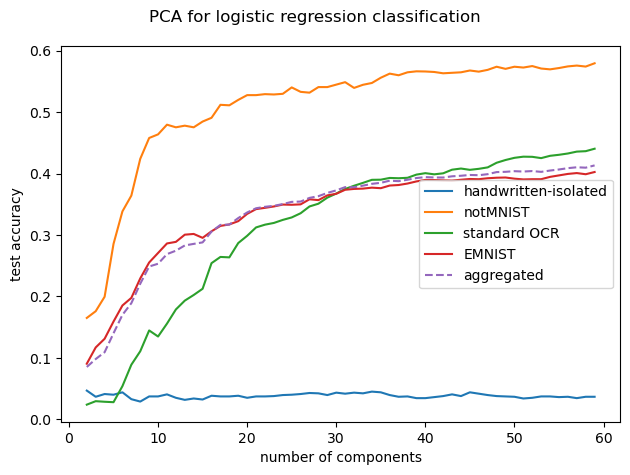

In [237]:
plot_scores(logreg_pca_results, range(2, 60), title="PCA for logistic regression classification")

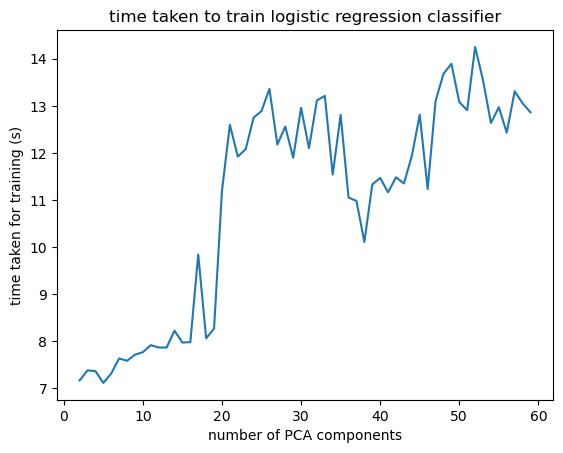

In [39]:
plt.plot(range(2, 60), logreg_pca_results["traintimes"], label="predict time")
plt.xlabel("number of PCA components")
plt.ylabel("time taken for training (s)")
plt.title("time taken to train logistic regression classifier")
plt.show()

### KNN classifier

In [40]:
knn_pca_results = test_trf_models(create_knn, pcatrf_funcs, 2, 59)

n_components: 2
KNN training took: 0.30981898307800293 sec.

Model testing took: 0.2625882625579834 sec.

handwritten-isolated score: 0.28683035714285715
notMNIST score: 0.18830128205128205
standard OCR score: 0.053424335137679455
EMNIST score: 0.10538078047103318
Aggregate score: 0.13197026022304834
------
n_components: 3
KNN training took: 0.20292282104492188 sec.

Model testing took: 0.26331496238708496 sec.

handwritten-isolated score: 0.3236607142857143
notMNIST score: 0.2932692307692308
standard OCR score: 0.09037420569545776
EMNIST score: 0.15042117930204574
Aggregate score: 0.1882450967824638
------
n_components: 4
KNN training took: 0.18558287620544434 sec.

Model testing took: 0.29886794090270996 sec.

handwritten-isolated score: 0.33816964285714285
notMNIST score: 0.39449786324786323
standard OCR score: 0.1772181689809367
EMNIST score: 0.19580539797146296
Aggregate score: 0.2547750288424561
------
n_components: 5
KNN training took: 0.1974189281463623 sec.

Model testing took

In [246]:
np.max(knn_pca_results["aggscores"])

0.7690039738495065

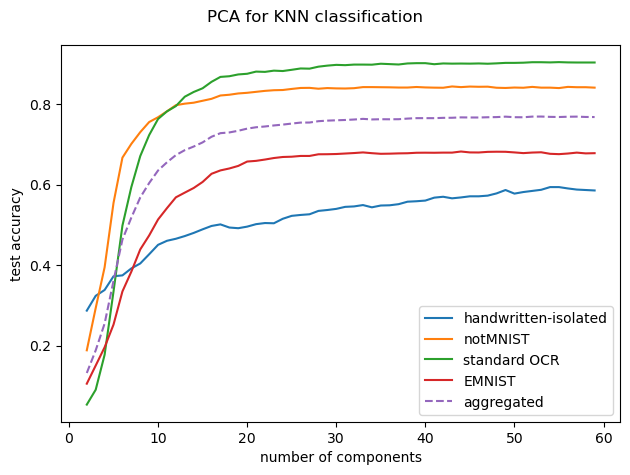

In [238]:
plot_scores(knn_pca_results, range(2, 60), title="PCA for KNN classification")

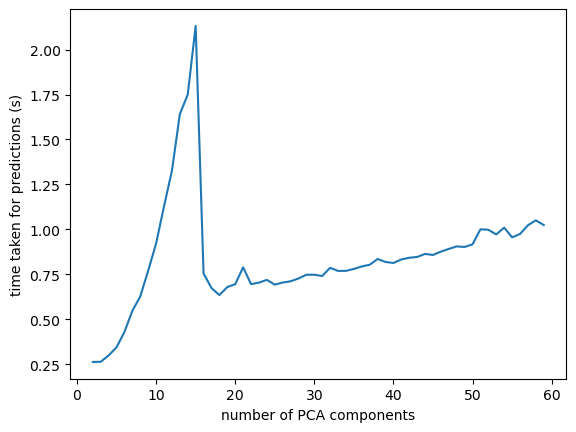

In [42]:
plt.plot(range(2, 60), knn_pca_results["predicttimes"], label="predict time")
plt.xlabel("number of PCA components")
plt.ylabel("time taken for predictions (s)")
plt.show()

## Tests with LDA

In [43]:
def create_lda(X, y, n_components):
    ts = tic()
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    lda.fit(X, y)
    toc(ts, "Creating LDA components")
    return lda
allldas = [create_lda(cons_train_data, cons_train_labels, i) for i in range(1, 35)]
ldatrf_funcs = [lda.transform for lda in allldas]

Creating LDA components took: 8.295714855194092 sec.

Creating LDA components took: 7.097922086715698 sec.

Creating LDA components took: 7.479964971542358 sec.

Creating LDA components took: 7.376833200454712 sec.

Creating LDA components took: 6.996621131896973 sec.

Creating LDA components took: 6.989284038543701 sec.

Creating LDA components took: 7.127906084060669 sec.

Creating LDA components took: 7.101445913314819 sec.

Creating LDA components took: 6.693737983703613 sec.

Creating LDA components took: 7.15224289894104 sec.

Creating LDA components took: 6.953445672988892 sec.

Creating LDA components took: 7.293007135391235 sec.

Creating LDA components took: 7.508800029754639 sec.

Creating LDA components took: 6.853917837142944 sec.

Creating LDA components took: 6.849837064743042 sec.

Creating LDA components took: 7.383708238601685 sec.

Creating LDA components took: 7.266784906387329 sec.

Creating LDA components took: 7.048354148864746 sec.

Creating LDA components took:

In [44]:
ldatrf_funcs = [lda.transform for lda in allldas]

### Logistic regression linear classifier

In [45]:
logreg_lda_results = test_trf_models(create_logreg, ldatrf_funcs, 1, 34)

n_components: 1
Logistic Regression training took: 5.2648231983184814 sec.

Model testing took: 0.11049103736877441 sec.

handwritten-isolated score: 0.03850446428571429
notMNIST score: 0.15117521367521367
standard OCR score: 0.023064250411861616
EMNIST score: 0.06016847172081829
Aggregate score: 0.06941417766952955
------
n_components: 2
Logistic Regression training took: 6.985913038253784 sec.

Model testing took: 0.08062386512756348 sec.

handwritten-isolated score: 0.03571428571428571
notMNIST score: 0.17761752136752137
standard OCR score: 0.02165215344787009
EMNIST score: 0.13838748495788206
Aggregate score: 0.10421740802461223
------
n_components: 3


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.081530809402466 sec.

Model testing took: 0.09317302703857422 sec.

handwritten-isolated score: 0.03236607142857143
notMNIST score: 0.20566239316239315
standard OCR score: 0.05530713108966816
EMNIST score: 0.2031975244971635
Aggregate score: 0.1438918087424689
------
n_components: 4


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.465492010116577 sec.

Model testing took: 0.14303278923034668 sec.

handwritten-isolated score: 0.03515625
notMNIST score: 0.29967948717948717
standard OCR score: 0.089668157213462
EMNIST score: 0.2241705346398487
Aggregate score: 0.18395077554159722
------
n_components: 5


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.517109155654907 sec.

Model testing took: 0.09659600257873535 sec.

handwritten-isolated score: 0.045200892857142856
notMNIST score: 0.38247863247863245
standard OCR score: 0.08872675923746765
EMNIST score: 0.2692109334708613
Aggregate score: 0.22151006281245994
------
n_components: 6


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 8.16355299949646 sec.

Model testing took: 0.09105992317199707 sec.

handwritten-isolated score: 0.05022321428571429
notMNIST score: 0.4265491452991453
standard OCR score: 0.13767945398917392
EMNIST score: 0.28279181708784595
Aggregate score: 0.251057556723497
------
n_components: 7


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.530684947967529 sec.

Model testing took: 0.10907816886901855 sec.

handwritten-isolated score: 0.05133928571428571
notMNIST score: 0.4754273504273504
standard OCR score: 0.20122381736879266
EMNIST score: 0.30806257521058966
Aggregate score: 0.28964235354441736
------
n_components: 8


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.514027118682861 sec.

Model testing took: 0.10378503799438477 sec.

handwritten-isolated score: 0.05412946428571429
notMNIST score: 0.5251068376068376
standard OCR score: 0.22805365968463168
EMNIST score: 0.3235344679388001
Aggregate score: 0.3149596205614665
------
n_components: 9


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.534826993942261 sec.

Model testing took: 0.07450985908508301 sec.

handwritten-isolated score: 0.048549107142857144
notMNIST score: 0.5384615384615384
standard OCR score: 0.26429748176041423
EMNIST score: 0.33178614406051227
Aggregate score: 0.330470452506089
------
n_components: 10


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 8.259854793548584 sec.

Model testing took: 0.09548091888427734 sec.

handwritten-isolated score: 0.05022321428571429
notMNIST score: 0.5486111111111112
standard OCR score: 0.28853847964226875
EMNIST score: 0.3439917483238783
Aggregate score: 0.3442507370849891
------
n_components: 11


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.680356740951538 sec.

Model testing took: 0.174713134765625 sec.

handwritten-isolated score: 0.052455357142857144
notMNIST score: 0.5584935897435898
standard OCR score: 0.3036008472581784
EMNIST score: 0.3506962351727695
Aggregate score: 0.35348032303550825
------
n_components: 12


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.9157891273498535 sec.

Model testing took: 0.11433291435241699 sec.

handwritten-isolated score: 0.05412946428571429
notMNIST score: 0.5758547008547008
standard OCR score: 0.3330195340080019
EMNIST score: 0.3548220732336256
Aggregate score: 0.3673887963081656
------
n_components: 13


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.3780739307403564 sec.

Model testing took: 0.08412599563598633 sec.

handwritten-isolated score: 0.053013392857142856
notMNIST score: 0.5830662393162394
standard OCR score: 0.3469051541539186
EMNIST score: 0.3613546501633144
Aggregate score: 0.3752083066273555
------
n_components: 14


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.870447874069214 sec.

Model testing took: 0.09506416320800781 sec.

handwritten-isolated score: 0.056361607142857144
notMNIST score: 0.5860042735042735
standard OCR score: 0.3678512591197929
EMNIST score: 0.36462093862815886
Aggregate score: 0.38322009998718115
------
n_components: 15


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.633127927780151 sec.

Model testing took: 0.0867009162902832 sec.

handwritten-isolated score: 0.05803571428571429
notMNIST score: 0.5924145299145299
standard OCR score: 0.38220757825370677
EMNIST score: 0.36479284854736116
Aggregate score: 0.388924496859377
------
n_components: 16


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.726863861083984 sec.

Model testing took: 0.06970596313476562 sec.

handwritten-isolated score: 0.05970982142857143
notMNIST score: 0.5958867521367521
standard OCR score: 0.3967992468816192
EMNIST score: 0.3677153171738009
Aggregate score: 0.3950134598128445
------
n_components: 17


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.8010218143463135 sec.

Model testing took: 0.07627081871032715 sec.

handwritten-isolated score: 0.060825892857142856
notMNIST score: 0.6004273504273504
standard OCR score: 0.40315368321958106
EMNIST score: 0.3653085783049682
Aggregate score: 0.3970644789129599
------
n_components: 18


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.846052169799805 sec.

Model testing took: 0.07159614562988281 sec.

handwritten-isolated score: 0.05915178571428571
notMNIST score: 0.6025641025641025
standard OCR score: 0.40950811955754296
EMNIST score: 0.36823104693140796
Aggregate score: 0.4002051019100115
------
n_components: 19
Logistic Regression training took: 7.8089799880981445 sec.

Model testing took: 0.10762691497802734 sec.

handwritten-isolated score: 0.05747767857142857
notMNIST score: 0.5993589743589743
standard OCR score: 0.4165686043775006
EMNIST score: 0.3757950833763108
Aggregate score: 0.40398666837584923
------
n_components: 20
Logistic Regression training took: 7.679417133331299 sec.

Model testing took: 0.09687924385070801 sec.

handwritten-isolated score: 0.05970982142857143
notMNIST score: 0.6055021367521367
standard OCR score: 0.4295128265474229
EMNIST score: 0.37596699329551314
Aggregate score: 0.4093064991667735
------
n_components: 21


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.041586875915527 sec.

Model testing took: 0.08385205268859863 sec.

handwritten-isolated score: 0.0625
notMNIST score: 0.6006944444444444
standard OCR score: 0.4389268063073664
EMNIST score: 0.3816400206291903
Aggregate score: 0.4131521599794898
------
n_components: 22


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.500354766845703 sec.

Model testing took: 0.09325122833251953 sec.

handwritten-isolated score: 0.06473214285714286
notMNIST score: 0.5985576923076923
standard OCR score: 0.44551659213932693
EMNIST score: 0.3849063090940347
Aggregate score: 0.41590821689526986
------
n_components: 23


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.604033946990967 sec.

Model testing took: 0.07222294807434082 sec.

handwritten-isolated score: 0.0625
notMNIST score: 0.5900106837606838
standard OCR score: 0.45045893151329724
EMNIST score: 0.3880006876396768
Aggregate score: 0.41610049993590564
------
n_components: 24


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.379012107849121 sec.

Model testing took: 0.07585692405700684 sec.

handwritten-isolated score: 0.06529017857142858
notMNIST score: 0.594284188034188
standard OCR score: 0.45493057189927044
EMNIST score: 0.38971978683170017
Aggregate score: 0.41930521727983594
------
n_components: 25


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.482293844223022 sec.

Model testing took: 0.09763097763061523 sec.

handwritten-isolated score: 0.060267857142857144
notMNIST score: 0.5910790598290598
standard OCR score: 0.4575194163332549
EMNIST score: 0.3890321471548908
Aggregate score: 0.41840789642353543
------
n_components: 26


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.901209115982056 sec.

Model testing took: 0.07338213920593262 sec.

handwritten-isolated score: 0.06696428571428571
notMNIST score: 0.5854700854700855
standard OCR score: 0.463167804189221
EMNIST score: 0.3904074265085095
Aggregate score: 0.41988206640174336
------
n_components: 27
Logistic Regression training took: 13.511219024658203 sec.

Model testing took: 0.09560871124267578 sec.

handwritten-isolated score: 0.06808035714285714
notMNIST score: 0.5838675213675214
standard OCR score: 0.4634031536832196
EMNIST score: 0.3890321471548908
Aggregate score: 0.4191770285860787
------
n_components: 28


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.430806875228882 sec.

Model testing took: 0.06527185440063477 sec.

handwritten-isolated score: 0.06919642857142858
notMNIST score: 0.5836004273504274
standard OCR score: 0.4664626971052012
EMNIST score: 0.3888602372356885
Aggregate score: 0.42001025509550055
------
n_components: 29


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.037751197814941 sec.

Model testing took: 0.07311367988586426 sec.

handwritten-isolated score: 0.06919642857142858
notMNIST score: 0.5822649572649573
standard OCR score: 0.463167804189221
EMNIST score: 0.38782877772047447
Aggregate score: 0.41840789642353543
------
n_components: 30


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.89873719215393 sec.

Model testing took: 0.07908511161804199 sec.

handwritten-isolated score: 0.06696428571428571
notMNIST score: 0.5814636752136753
standard OCR score: 0.46481525064721113
EMNIST score: 0.3871411380436651
Aggregate score: 0.41815151903602105
------
n_components: 31
Logistic Regression training took: 10.252357006072998 sec.

Model testing took: 0.07051396369934082 sec.

handwritten-isolated score: 0.06305803571428571
notMNIST score: 0.5779914529914529
standard OCR score: 0.46669804659919983
EMNIST score: 0.3866254082860581
Aggregate score: 0.41719010383284194
------
n_components: 32


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.780403137207031 sec.

Model testing took: 0.07480597496032715 sec.

handwritten-isolated score: 0.060267857142857144
notMNIST score: 0.5793269230769231
standard OCR score: 0.4688161920451871
EMNIST score: 0.3831872099020113
Aggregate score: 0.4164850660171773
------
n_components: 33


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.85071086883545 sec.

Model testing took: 0.06238675117492676 sec.

handwritten-isolated score: 0.0625
notMNIST score: 0.5774572649572649
standard OCR score: 0.4695222405271829
EMNIST score: 0.3847343991748324
Aggregate score: 0.41706191513908475
------
n_components: 34
Logistic Regression training took: 12.010543823242188 sec.

Model testing took: 0.10824704170227051 sec.

handwritten-isolated score: 0.06584821428571429
notMNIST score: 0.5758547008547008
standard OCR score: 0.4688161920451871
EMNIST score: 0.3828433900636067
Aggregate score: 0.41616459428278424
------


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [247]:
np.max(logreg_lda_results["aggscores"])

0.42001025509550055

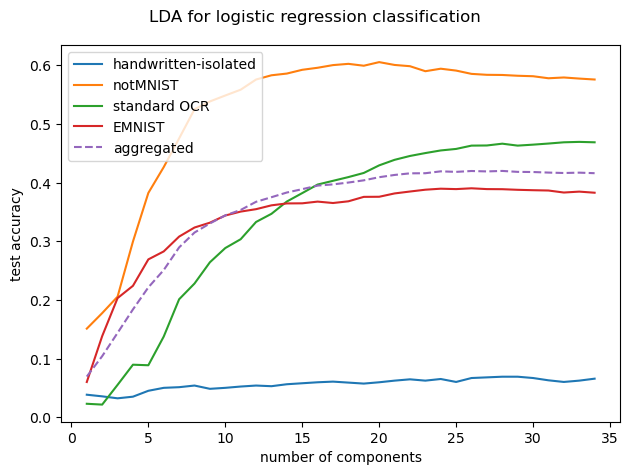

In [239]:
plot_scores(logreg_lda_results, range(1, 35), title="LDA for logistic regression classification")

### KNN classifier

In [47]:
knn_lda_results = test_trf_models(create_knn, ldatrf_funcs, 1, 34)

n_components: 1
KNN training took: 0.4339418411254883 sec.

Model testing took: 0.3401520252227783 sec.

handwritten-isolated score: 0.19419642857142858
notMNIST score: 0.08627136752136752
standard OCR score: 0.036243822075782535
EMNIST score: 0.057589822932783225
Aggregate score: 0.07434944237918216
------
n_components: 2
KNN training took: 0.23886990547180176 sec.

Model testing took: 0.3389618396759033 sec.

handwritten-isolated score: 0.23716517857142858
notMNIST score: 0.14289529914529914
standard OCR score: 0.05201223817368793
EMNIST score: 0.13099535843218155
Aggregate score: 0.12453531598513011
------
n_components: 3
KNN training took: 0.33748722076416016 sec.

Model testing took: 0.31865382194519043 sec.

handwritten-isolated score: 0.30691964285714285
notMNIST score: 0.25587606837606836
standard OCR score: 0.11508590256530948
EMNIST score: 0.17552002750558707
Aggregate score: 0.1934367388796308
------
n_components: 4
KNN training took: 0.2105271816253662 sec.

Model testing t

In [248]:
np.max(knn_lda_results["aggscores"])

0.6516472247147802

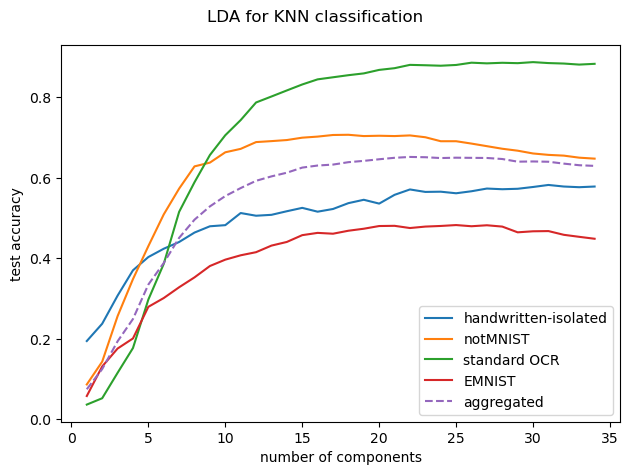

In [240]:
plot_scores(knn_lda_results, range(1, 35), title="LDA for KNN classification")

## Tests with random Gaussian projection

In [49]:
allgrps = [GaussianRandomProjection(n_components=i, random_state=1).fit(cons_train_data) for i in range(2, 60)]
rgptrf_funcs = [grp.transform for grp in allgrps]

### Logistic regression

In [50]:
logreg_rgp_results = test_trf_models(create_logreg, rgptrf_funcs, 2, 59)

n_components: 2


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.477319955825806 sec.

Model testing took: 0.06003379821777344 sec.

handwritten-isolated score: 0.045200892857142856
notMNIST score: 0.13007478632478633
standard OCR score: 0.02494704636385032
EMNIST score: 0.008251676121712223
Aggregate score: 0.04627611844635303
------
n_components: 3


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.75170111656189 sec.

Model testing took: 0.04214000701904297 sec.

handwritten-isolated score: 0.04296875
notMNIST score: 0.13862179487179488
standard OCR score: 0.023299599905860204
EMNIST score: 0.036101083032490974
Aggregate score: 0.0580053839251378
------
n_components: 4


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.022233963012695 sec.

Model testing took: 0.052789926528930664 sec.

handwritten-isolated score: 0.045200892857142856
notMNIST score: 0.18242521367521367
standard OCR score: 0.029889385737820663
EMNIST score: 0.07770328347945676
Aggregate score: 0.08607870785796692
------
n_components: 5


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.093755006790161 sec.

Model testing took: 0.04597187042236328 sec.

handwritten-isolated score: 0.04799107142857143
notMNIST score: 0.20032051282051283
standard OCR score: 0.03153683219581078
EMNIST score: 0.098676293622142
Aggregate score: 0.0989616715805666
------
n_components: 6


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.219892263412476 sec.

Model testing took: 0.05103492736816406 sec.

handwritten-isolated score: 0.04631696428571429
notMNIST score: 0.21287393162393162
standard OCR score: 0.04024476347375853
EMNIST score: 0.10606842014784253
Aggregate score: 0.10690937059351366
------
n_components: 7


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.293278932571411 sec.

Model testing took: 0.03974604606628418 sec.

handwritten-isolated score: 0.04185267857142857
notMNIST score: 0.22889957264957264
standard OCR score: 0.038361967521769826
EMNIST score: 0.12154031287605295
Aggregate score: 0.11549801307524676
------
n_components: 8


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.135499000549316 sec.

Model testing took: 0.02912592887878418 sec.

handwritten-isolated score: 0.04352678571428571
notMNIST score: 0.23210470085470086
standard OCR score: 0.04495175335373029
EMNIST score: 0.12308750214887398
Aggregate score: 0.11883091911293424
------
n_components: 9


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.147303819656372 sec.

Model testing took: 0.03455018997192383 sec.

handwritten-isolated score: 0.045200892857142856
notMNIST score: 0.26335470085470086
standard OCR score: 0.04401035537773594
EMNIST score: 0.12962007907856282
Aggregate score: 0.12870144853223944
------
n_components: 10


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.370280981063843 sec.

Model testing took: 0.044284820556640625 sec.

handwritten-isolated score: 0.05133928571428571
notMNIST score: 0.29941239316239315
standard OCR score: 0.04377500588373735
EMNIST score: 0.1457796114835826
Aggregate score: 0.14401999743622612
------
n_components: 11


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.846315860748291 sec.

Model testing took: 0.04686903953552246 sec.

handwritten-isolated score: 0.06194196428571429
notMNIST score: 0.30074786324786323
standard OCR score: 0.05530713108966816
EMNIST score: 0.15626611655492523
Aggregate score: 0.15260863991795923
------
n_components: 12


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.625219106674194 sec.

Model testing took: 0.03953194618225098 sec.

handwritten-isolated score: 0.06138392857142857
notMNIST score: 0.31810897435897434
standard OCR score: 0.06142621793363144
EMNIST score: 0.15832903558535327
Aggregate score: 0.15914626329957698
------
n_components: 13


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.642249822616577 sec.

Model testing took: 0.044595956802368164 sec.

handwritten-isolated score: 0.060267857142857144
notMNIST score: 0.32905982905982906
standard OCR score: 0.06283831489762297
EMNIST score: 0.16623689186866084
Aggregate score: 0.16497884886553005
------
n_components: 14


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.543946027755737 sec.

Model testing took: 0.047300100326538086 sec.

handwritten-isolated score: 0.05803571428571429
notMNIST score: 0.34962606837606836
standard OCR score: 0.0738997411155566
EMNIST score: 0.16898745057589823
Aggregate score: 0.17369568004102037
------
n_components: 15


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.655833959579468 sec.

Model testing took: 0.046600341796875 sec.

handwritten-isolated score: 0.05580357142857143
notMNIST score: 0.34935897435897434
standard OCR score: 0.07837138150152977
EMNIST score: 0.18119305483926423
Aggregate score: 0.17914369952570183
------
n_components: 16


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 8.508573055267334 sec.

Model testing took: 0.06225991249084473 sec.

handwritten-isolated score: 0.05189732142857143
notMNIST score: 0.36698717948717946
standard OCR score: 0.08143092492351141
EMNIST score: 0.18583462265772735
Aggregate score: 0.18548903986668375
------
n_components: 17


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.990445852279663 sec.

Model testing took: 0.049449920654296875 sec.

handwritten-isolated score: 0.05859375
notMNIST score: 0.3640491452991453
standard OCR score: 0.09578724405742528
EMNIST score: 0.19374247894103488
Aggregate score: 0.19241122932957314
------
n_components: 18


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 8.441936016082764 sec.

Model testing took: 0.07461094856262207 sec.

handwritten-isolated score: 0.05970982142857143
notMNIST score: 0.4017094017094017
standard OCR score: 0.09366909861143799
EMNIST score: 0.20216606498194944
Aggregate score: 0.20414049480835791
------
n_components: 19


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 9.381692171096802 sec.

Model testing took: 0.07815909385681152 sec.

handwritten-isolated score: 0.04799107142857143
notMNIST score: 0.4153311965811966
standard OCR score: 0.10567192280536597
EMNIST score: 0.21110538078047103
Aggregate score: 0.2126650429432124
------
n_components: 20


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 9.348419666290283 sec.

Model testing took: 0.10507798194885254 sec.

handwritten-isolated score: 0.04799107142857143
notMNIST score: 0.4169337606837607
standard OCR score: 0.11743939750529536
EMNIST score: 0.22193570569021834
Aggregate score: 0.22029227022176645
------
n_components: 21


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 9.420599937438965 sec.

Model testing took: 0.07628417015075684 sec.

handwritten-isolated score: 0.046875
notMNIST score: 0.43162393162393164
standard OCR score: 0.12167568839726994
EMNIST score: 0.22021660649819494
Aggregate score: 0.22420202538136136
------
n_components: 22


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.31947112083435 sec.

Model testing took: 0.060353994369506836 sec.

handwritten-isolated score: 0.05133928571428571
notMNIST score: 0.4407051282051282
standard OCR score: 0.13344316309719934
EMNIST score: 0.22537390407426508
Aggregate score: 0.2320215357005512
------
n_components: 23


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.81812572479248 sec.

Model testing took: 0.05161309242248535 sec.

handwritten-isolated score: 0.04799107142857143
notMNIST score: 0.43669871794871795
standard OCR score: 0.14615203577312308
EMNIST score: 0.22915592229671652
Aggregate score: 0.2355467247788745
------
n_components: 24


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.07243800163269 sec.

Model testing took: 0.054779052734375 sec.

handwritten-isolated score: 0.04743303571428571
notMNIST score: 0.43482905982905984
standard OCR score: 0.15839020946104965
EMNIST score: 0.23242221076156094
Aggregate score: 0.23958466863222663
------
n_components: 25


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.918214082717896 sec.

Model testing took: 0.09815597534179688 sec.

handwritten-isolated score: 0.05915178571428571
notMNIST score: 0.43990384615384615
standard OCR score: 0.15980230642504117
EMNIST score: 0.233969400034382
Aggregate score: 0.24310985771054994
------
n_components: 26


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.021055936813354 sec.

Model testing took: 0.08961892127990723 sec.

handwritten-isolated score: 0.060267857142857144
notMNIST score: 0.437767094017094
standard OCR score: 0.16898093669098613
EMNIST score: 0.24050197696407083
Aggregate score: 0.24766055633893092
------
n_components: 27


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.08126187324524 sec.

Model testing took: 0.05646991729736328 sec.

handwritten-isolated score: 0.05412946428571429
notMNIST score: 0.4441773504273504
standard OCR score: 0.1675688397269946
EMNIST score: 0.24875365308578304
Aggregate score: 0.2511857454172542
------
n_components: 28


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.952026844024658 sec.

Model testing took: 0.06286001205444336 sec.

handwritten-isolated score: 0.05022321428571429
notMNIST score: 0.44551282051282054
standard OCR score: 0.17580607201694518
EMNIST score: 0.2504727522778064
Aggregate score: 0.2539418023330342
------
n_components: 29


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.270999908447266 sec.

Model testing took: 0.05590510368347168 sec.

handwritten-isolated score: 0.04966517857142857
notMNIST score: 0.45886752136752135
standard OCR score: 0.17698281948693811
EMNIST score: 0.25236376138903216
Aggregate score: 0.25810793488014355
------
n_components: 30


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.099159717559814 sec.

Model testing took: 0.07254910469055176 sec.

handwritten-isolated score: 0.05357142857142857
notMNIST score: 0.4497863247863248
standard OCR score: 0.18216050835490705
EMNIST score: 0.25545813993467426
Aggregate score: 0.25894116138956547
------
n_components: 31


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.1632821559906 sec.

Model testing took: 0.06832718849182129 sec.

handwritten-isolated score: 0.045200892857142856
notMNIST score: 0.4594017094017094
standard OCR score: 0.18616144975288304
EMNIST score: 0.25648959944988825
Aggregate score: 0.2617613126522241
------
n_components: 32


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.787233829498291 sec.

Model testing took: 0.0744631290435791 sec.

handwritten-isolated score: 0.05189732142857143
notMNIST score: 0.4620726495726496
standard OCR score: 0.19369263356083785
EMNIST score: 0.26044352759154205
Aggregate score: 0.2666965773618767
------
n_components: 33


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.682045936584473 sec.

Model testing took: 0.05135798454284668 sec.

handwritten-isolated score: 0.05022321428571429
notMNIST score: 0.46634615384615385
standard OCR score: 0.2024005648387856
EMNIST score: 0.2630221763795771
Aggregate score: 0.27086270990898603
------
n_components: 34


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.606274127960205 sec.

Model testing took: 0.11459803581237793 sec.

handwritten-isolated score: 0.04575892857142857
notMNIST score: 0.4655448717948718
standard OCR score: 0.20663685573076018
EMNIST score: 0.2656008251676122
Aggregate score: 0.27227278554031537
------
n_components: 35


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.157460927963257 sec.

Model testing took: 0.053270578384399414 sec.

handwritten-isolated score: 0.04799107142857143
notMNIST score: 0.46821581196581197
standard OCR score: 0.20710755471875736
EMNIST score: 0.2657727350868145
Aggregate score: 0.2733623894372516
------
n_components: 36


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.633501052856445 sec.

Model testing took: 0.06318902969360352 sec.

handwritten-isolated score: 0.04966517857142857
notMNIST score: 0.46073717948717946
standard OCR score: 0.22052247587667687
EMNIST score: 0.2688671136324566
Aggregate score: 0.2765671067811819
------
n_components: 37


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.575781106948853 sec.

Model testing took: 0.05617880821228027 sec.

handwritten-isolated score: 0.045200892857142856
notMNIST score: 0.4658119658119658
standard OCR score: 0.21510943751470935
EMNIST score: 0.27075812274368233
Aggregate score: 0.2765030124343033
------
n_components: 38


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.632541179656982 sec.

Model testing took: 0.06175875663757324 sec.

handwritten-isolated score: 0.04743303571428571
notMNIST score: 0.4634081196581197
standard OCR score: 0.21746293245469522
EMNIST score: 0.2697266632284683
Aggregate score: 0.2764389180874247
------
n_components: 39


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.229336023330688 sec.

Model testing took: 0.05269217491149902 sec.

handwritten-isolated score: 0.046875
notMNIST score: 0.46287393162393164
standard OCR score: 0.22617086373264297
EMNIST score: 0.27780642943097816
Aggregate score: 0.2816305601845917
------
n_components: 40


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.282476902008057 sec.

Model testing took: 0.07298517227172852 sec.

handwritten-isolated score: 0.04631696428571429
notMNIST score: 0.4700854700854701
standard OCR score: 0.22899505766062603
EMNIST score: 0.2802131682998109
Aggregate score: 0.2849634662222792
------
n_components: 41


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.483868837356567 sec.

Model testing took: 0.09111213684082031 sec.

handwritten-isolated score: 0.049107142857142856
notMNIST score: 0.4751602564102564
standard OCR score: 0.23370204754059778
EMNIST score: 0.2774626095925735
Aggregate score: 0.28675810793488016
------
n_components: 42


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.179212093353271 sec.

Model testing took: 0.051905155181884766 sec.

handwritten-isolated score: 0.052455357142857144
notMNIST score: 0.47489316239316237
standard OCR score: 0.240997881854554
EMNIST score: 0.283307546845453
Aggregate score: 0.29124471221638254
------
n_components: 43


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.569936037063599 sec.

Model testing took: 0.06986308097839355 sec.

handwritten-isolated score: 0.05022321428571429
notMNIST score: 0.47836538461538464
standard OCR score: 0.24076253236055542
EMNIST score: 0.284854736118274
Aggregate score: 0.2923343161133188
------
n_components: 44


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.525080919265747 sec.

Model testing took: 0.054810285568237305 sec.

handwritten-isolated score: 0.04966517857142857
notMNIST score: 0.48157051282051283
standard OCR score: 0.2452341727465286
EMNIST score: 0.2905277634519512
Aggregate score: 0.29637225996667094
------
n_components: 45


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.482002973556519 sec.

Model testing took: 0.10921788215637207 sec.

handwritten-isolated score: 0.049107142857142856
notMNIST score: 0.4810363247863248
standard OCR score: 0.25817839491645095
EMNIST score: 0.2893243940175348
Aggregate score: 0.2992565055762082
------
n_components: 46


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.706728219985962 sec.

Model testing took: 0.0725698471069336 sec.

handwritten-isolated score: 0.046875
notMNIST score: 0.4909188034188034
standard OCR score: 0.2577076959284538
EMNIST score: 0.29121540312876054
Aggregate score: 0.3019484681451096
------
n_components: 47


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.962779760360718 sec.

Model testing took: 0.1029057502746582 sec.

handwritten-isolated score: 0.044642857142857144
notMNIST score: 0.4893162393162393
standard OCR score: 0.25817839491645095
EMNIST score: 0.29568506102802133
Aggregate score: 0.3031021663889245
------
n_components: 48


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.092559814453125 sec.

Model testing took: 0.07158708572387695 sec.

handwritten-isolated score: 0.049107142857142856
notMNIST score: 0.4954594017094017
standard OCR score: 0.26241468580842553
EMNIST score: 0.2994670792504728
Aggregate score: 0.3076528650173055
------
n_components: 49


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.132642984390259 sec.

Model testing took: 0.05672883987426758 sec.

handwritten-isolated score: 0.048549107142857144
notMNIST score: 0.49412393162393164
standard OCR score: 0.26735702518239585
EMNIST score: 0.3011861784424961
Aggregate score: 0.3092552236892706
------
n_components: 50


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.190838098526001 sec.

Model testing took: 0.08099818229675293 sec.

handwritten-isolated score: 0.04799107142857143
notMNIST score: 0.49038461538461536
standard OCR score: 0.2744175100023535
EMNIST score: 0.2996389891696751
Aggregate score: 0.30963978977054224
------
n_components: 51


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.298147916793823 sec.

Model testing took: 0.05516815185546875 sec.

handwritten-isolated score: 0.04743303571428571
notMNIST score: 0.48691239316239315
standard OCR score: 0.283831489762297
EMNIST score: 0.3006704486848891
Aggregate score: 0.3116908088706576
------
n_components: 52


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.951811075210571 sec.

Model testing took: 0.0705420970916748 sec.

handwritten-isolated score: 0.04408482142857143
notMNIST score: 0.4874465811965812
standard OCR score: 0.28689103318427867
EMNIST score: 0.3023895478769125
Aggregate score: 0.31290860146135113
------
n_components: 53


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.454960107803345 sec.

Model testing took: 0.07004427909851074 sec.

handwritten-isolated score: 0.04408482142857143
notMNIST score: 0.48183760683760685
standard OCR score: 0.2901859261002589
EMNIST score: 0.3015299982809008
Aggregate score: 0.31213946929880787
------
n_components: 54


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 14.032917976379395 sec.

Model testing took: 0.07676911354064941 sec.

handwritten-isolated score: 0.04743303571428571
notMNIST score: 0.49278846153846156
standard OCR score: 0.2894798776182631
EMNIST score: 0.30582774626095927
Aggregate score: 0.3165619792334316
------
n_components: 55


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.927345752716064 sec.

Model testing took: 0.05742502212524414 sec.

handwritten-isolated score: 0.04799107142857143
notMNIST score: 0.4933226495726496
standard OCR score: 0.2963050129442222
EMNIST score: 0.31390751246346915
Aggregate score: 0.32162543263684146
------
n_components: 56


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.291918754577637 sec.

Model testing took: 0.1064751148223877 sec.

handwritten-isolated score: 0.04743303571428571
notMNIST score: 0.4946581196581197
standard OCR score: 0.2913626735702518
EMNIST score: 0.3164861612515042
Aggregate score: 0.3214972439430842
------
n_components: 57


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.059830665588379 sec.

Model testing took: 0.05170607566833496 sec.

handwritten-isolated score: 0.045200892857142856
notMNIST score: 0.4970619658119658
standard OCR score: 0.29089197458225463
EMNIST score: 0.3195805397971463
Aggregate score: 0.32284322522753495
------
n_components: 58


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.44815707206726 sec.

Model testing took: 0.06767511367797852 sec.

handwritten-isolated score: 0.04352678571428571
notMNIST score: 0.49439102564102566
standard OCR score: 0.2955989644622264
EMNIST score: 0.31700189100911125
Aggregate score: 0.32233047045250607
------
n_components: 59
Logistic Regression training took: 12.305787086486816 sec.

Model testing took: 0.09174704551696777 sec.

handwritten-isolated score: 0.04631696428571429
notMNIST score: 0.500534188034188
standard OCR score: 0.2977171099082137
EMNIST score: 0.320955819150765
Aggregate score: 0.3261761312652224
------


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [249]:
np.max(logreg_rgp_results["aggscores"])

0.3261761312652224

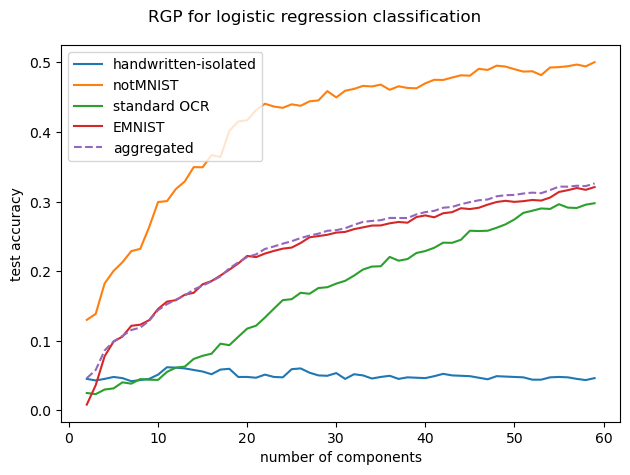

In [241]:
plot_scores(logreg_rgp_results, range(2, 60), title="RGP for logistic regression classification")

### KNN

In [52]:
knn_rgp_results = test_trf_models(create_knn, rgptrf_funcs, 2, 59)

n_components: 2
KNN training took: 0.22046804428100586 sec.

Model testing took: 0.26218533515930176 sec.

handwritten-isolated score: 0.23883928571428573
notMNIST score: 0.06543803418803419
standard OCR score: 0.02800658978583196
EMNIST score: 0.05260443527591542
Aggregate score: 0.07037559287270863
------
n_components: 3
KNN training took: 0.1386117935180664 sec.

Model testing took: 0.264693021774292 sec.

handwritten-isolated score: 0.2779017857142857
notMNIST score: 0.10069444444444445
standard OCR score: 0.04636385031772182
EMNIST score: 0.06377858002406739
Aggregate score: 0.09248814254582746
------
n_components: 4
KNN training took: 0.1363070011138916 sec.

Model testing took: 0.2878153324127197 sec.

handwritten-isolated score: 0.35044642857142855
notMNIST score: 0.1794871794871795
standard OCR score: 0.10849611673334902
EMNIST score: 0.09334708612686952
Aggregate score: 0.14767337520830662
------
n_components: 5
KNN training took: 0.11848998069763184 sec.

Model testing took:

In [250]:
np.max(knn_rgp_results["aggscores"])

0.6911293423920011

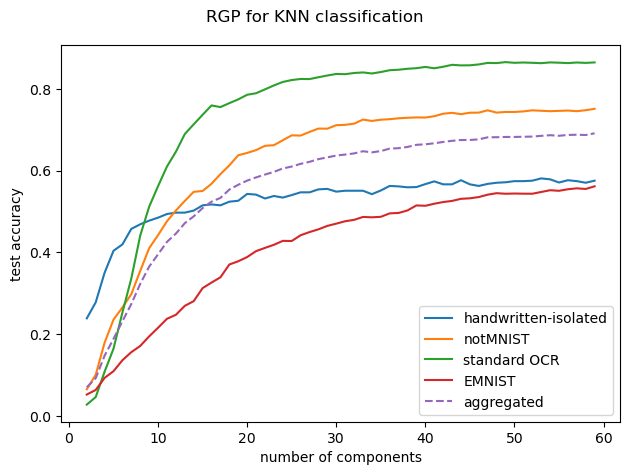

In [242]:
plot_scores(knn_rgp_results, range(2, 60), title="RGP for KNN classification")

## MPCA

Code taken from https://github.com/tensorly/Proceedings_IEEE_companion_notebooks/blob/master/MPCA.ipynb

In [227]:
def compute_modek_total_scatter(X, mode, factors):
    scatter = 0
    
    for m in range(len(X)):
        proj_but_k = tl.unfold(tl.tenalg.multi_mode_dot(X[m], factors, transpose=True, skip=mode), mode)
        scatter += tl.dot(proj_but_k, proj_but_k.T)
        
    return scatter

def MPCA(X, rank, niters=1, size=28):
    X = tl.tensor(X.reshape(-1, size, size).astype(float))
    Xmean = tl.mean(X, axis=0)
    X = X - Xmean
    factors = [tl.ones((dim, rank)) for dim in X.shape[1:]]

    num_modes = len(X.shape) - 1
    niters = niters

    for _ in range(niters):
        for k in range(num_modes):
            scatter = compute_modek_total_scatter(X, k, factors)
            U, _, _ = tl.tenalg.svd_interface(scatter, n_eigenvecs=rank)
            factors[k] = U

    def _MCPA_func(X):
        X = tl.tensor(X.reshape(-1, size, size).astype(float))
        X = X - Xmean
        res = tl.tenalg.multi_mode_dot(X, factors, modes=[1, 2], transpose=True)
        return res
    return _MCPA_func

# need this wrapper because defining lambdas in for loops just doesn't
# work like intended
def _get_flatten_mpca_func(mpca, rank):
    return lambda x: mpca(x).reshape(-1, rank ** 2)

allranks = list(range(4, 26))
allmpcas = [MPCA(cons_train_data, i, niters=1, size=28) for i in allranks]
mpcatrf_funcs = [_get_flatten_mpca_func(mpca, allranks[i]) for i, mpca in enumerate(allmpcas)]

### KNN

In [228]:
knn_mpca_results = test_trf_models(create_knn, mpcatrf_funcs, 4, 25)

n_components: 4
(69714, 4, 4)
KNN training took: 0.6621320247650146 sec.

(1792, 4, 4)
(3744, 4, 4)
(4249, 4, 4)
(5817, 4, 4)
Model testing took: 0.5949299335479736 sec.

handwritten-isolated score: 0.47767857142857145
notMNIST score: 0.7996794871794872
standard OCR score: 0.8519651682748882
EMNIST score: 0.5643802647412756
Aggregate score: 0.6892065119856429
------
n_components: 5
(69714, 5, 5)
KNN training took: 0.48925304412841797 sec.

(1792, 5, 5)
(3744, 5, 5)
(4249, 5, 5)
(5817, 5, 5)
Model testing took: 0.7188849449157715 sec.

handwritten-isolated score: 0.5128348214285714
notMNIST score: 0.8234508547008547
standard OCR score: 0.8846787479406919
EMNIST score: 0.6278150249269383
Aggregate score: 0.7315087809255224
------
n_components: 6
(69714, 6, 6)
KNN training took: 0.44685888290405273 sec.

(1792, 6, 6)
(3744, 6, 6)
(4249, 6, 6)
(5817, 6, 6)
Model testing took: 0.8749561309814453 sec.

handwritten-isolated score: 0.5334821428571429
notMNIST score: 0.8322649572649573
standard

In [251]:
np.max(knn_mpca_results["aggscores"])

0.7686835021151135

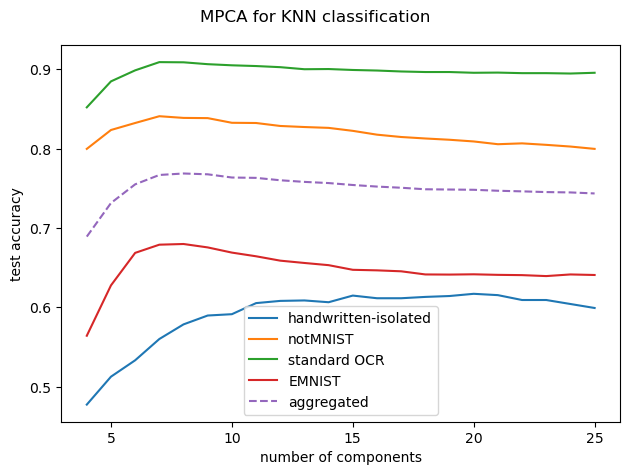

In [243]:
plot_scores(knn_mpca_results, range(4, 26), title="MPCA for KNN classification")

testing stuff here

In [102]:
X = tl.tensor(notmnist_test_data.reshape(-1, 28, 28).astype(float))
Xmean = tl.mean(X, axis=0)
Xcent = X - Xmean

In [230]:
mcpa = MPCA(X, 10)

In [231]:
asdf = mcpa(X)

(3744, 10, 10)


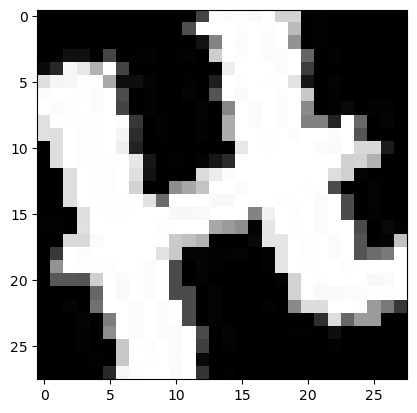

In [232]:
plt.imshow(X[0], cmap="gray")

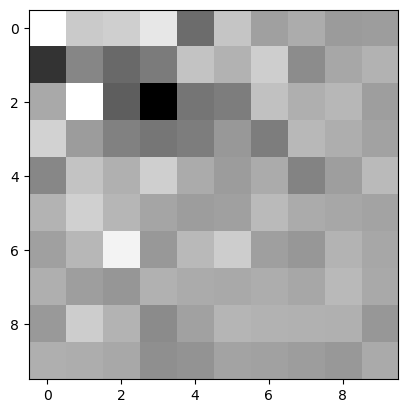

In [233]:
plt.imshow(asdf[0], cmap="gray")

## CNN tests

TODO these need to be done a datahub or someones laptop will explode